In [3]:
from fastai.tabular.all import *
import os
from pathlib import Path
import zipfile, kaggle

pd.options.display.float_format = '{:.2f}'.format  #Sets number of sig figs to display in table
set_seed(42)

In [4]:
path = Path('titanic')
if not path.exists(): #downloading from kaggle api
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
df = pd.read_csv(path/'train.csv')

In [6]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C


# Feature engineering

In [7]:
df.Cabin

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [12]:
df.groupby('Ticket')['Ticket'].transform("count")

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: Ticket, Length: 891, dtype: int64

In [24]:
def add_features(df):
    df['LogFare'] = np.log1p(df.Fare)
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG")) #Taking first letter and mapping to a dict of decks
    df['Family'] = df.SibSp + df.Parch
    df['Alone'] = df.Family == 0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform("count")
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0] #Splitting off the title
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")) #Mapping to str


In [25]:
add_features(df)

In [37]:
splits = RandomSplitter(seed = 42)(df)

In [38]:
dls = TabularPandas(
    df, splits=splits, #Use splits for indices of training and validation sets:
    procs = [Categorify, FillMissing, Normalize], #Turn strings into categories, fill missing values in numeric columns with the median, normalise all numeric columns:
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(), #The dependent variable is categorical (so build a classification model, not a regression model):


).dataloaders(path=".")

In [39]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
# automatically finds coefficients that will train

SuggestedLRs(slide=0.033113110810518265, valley=0.009120108559727669)

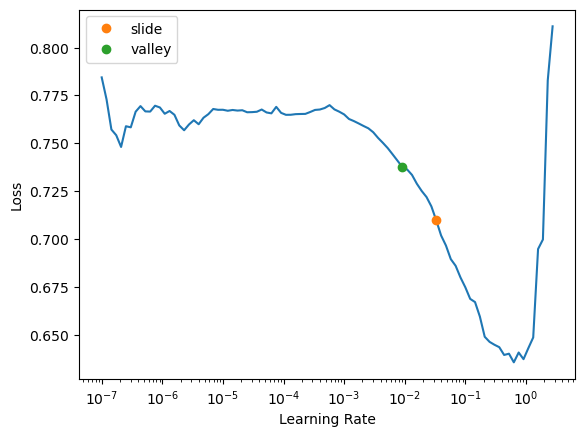

In [40]:
learn.lr_find(suggest_funcs= (slide,valley))
# Suggested learning rate should be somewhere between the slide and the valley

In [43]:
learn.fit(16, lr = 0.01)
# Similar accuracy to before

epoch,train_loss,valid_loss,accuracy,time
0,0.343528,0.472744,0.837079,00:00
1,0.328276,0.466033,0.837079,00:00
2,0.322950,0.464610,0.837079,00:00
3,0.317098,0.469567,0.831461,00:00
4,0.316086,0.474516,0.820225,00:00
5,0.318375,0.483186,0.825843,00:00
6,0.315009,0.498889,0.842697,00:00
7,0.318097,0.504635,0.831461,00:00
8,0.319480,0.521302,0.825843,00:00
9,0.320373,0.507734,0.825843,00:00


#  Ensembling

In [56]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [57]:
tst_dl = learn.dls.test_dl(tst_df)

In [73]:
tst_df.size

7106

In [58]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=([10,10]))
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr =0.01)
    return learn.get_preds(dl=tst_dl)[0]

In [59]:
# running ensemble 5 times and collecting results into a list
learns = [ensemble() for i in range(5)]
# gives 7106 x 5 results, 

In [74]:
ens_preds = torch.stack(learns).mean(0)

In [75]:
tst_df['Survived'] = (ens_preds[:,1] > 0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('ens_sub.csv', index=False)